# CareerCon 2019 - Help Navigate Robots
## This is a first take on this data, the main point is to perform some exploratory data analysis so we can:

#### 1. Understand better what the data is about
#### 2. What's the problem to be solved
#### 3. How could that be approached.



In [85]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Reading the data

We have two train .csv files, one for the response variable and another one for all the explanatory variables. And a test file.

In [212]:
cwd = os.chdir('/home/samuel/Work/coffe2/data/datacc2019')

data_train_path = '/home/samuel/Work/coffe2/data/datacc2019/X_train.csv'
response_train_path = '/home/samuel/Work/coffe2/data/datacc2019/y_train.csv'
test_data_path = '/home/samuel/Work/coffe2/data/datacc2019/X_test.csv'
sub_data_path = '/home/samuel/Work/coffe2/data/datacc2019/sample_submission.csv'

data_train = pd.read_csv(data_train_path)
response_train = pd.read_csv(response_train_path)
data_test = pd.read_csv(test_data_path)
sub_data = pd.read_csv(sub_data_path)

### Going into the 1. point of this notebook, let's see how this looks like

The 3 id's the data set is containing are defined as:

* row_id : The ID for this row.
* series_id: ID number for the measurement series. Foreign key to y_train/sample_submission.
* measurement_number: Measurement number within the series.

In [3]:
data_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [4]:
data_train.shape

(487680, 13)

Let's check what up with the ID's first.
* So far nothing wrong with *row_id*, as it should have as many unique values as rows in the train set.
* *series_id* should have as many unique values as rows in the response set, since it is its foreign key
* *measurement_numer* number of measurements for every each of the values in *series_id*

In [5]:
print( 'Counts row_id: ' + str(len(data_train['row_id'].unique())),
      '\nCounts series_id: ' + str(len(data_train['series_id'].unique())),
      '\nCounts measurement_number: ' + str(len(data_train['measurement_number'].unique())) 
     )

Counts row_id: 487680 
Counts series_id: 3810 
Counts measurement_number: 128


In [6]:
#all values in 'series_id' hold the same number of measurements
sum(data_train.groupby('series_id')['measurement_number'].count() !=128)

0

Then we have 
* 4 variables for orientation, 3 for angular velocity and 3 more for linear acceleration

Before checking what is up with them, let's quickly see what the test set is about:

#### response training set exploration

In [7]:
response_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


Let's try to understand what *group_id* means

In [8]:
#73 numbers for group id
len(response_train['group_id'].unique())

73

In [11]:
series_bygroupid = response_train.groupby('series_id')['group_id'].max()
groupid_counts = response_train.groupby('series_id')['group_id'].count()

series_bygroupid.head()

series_id
0    13
1    31
2    20
3    31
4    22
Name: group_id, dtype: int64

In [12]:
len(groupid_counts == 1)

3810

Let's plot 

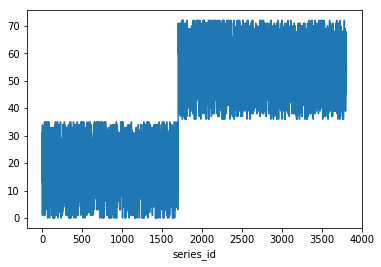

In [13]:
series_bygroupid.plot()

Ok now, what is this:

So we've plotted *series_id* against its maximum value for *group_id* (which happens to be the only value) and we can clearly see a change between the two halves of the set. 

Groups_id are numbers given for all those series recorded in a same measurement session. We can see a clear distinction between those series before ~1750 and after. 

That could mean series are not properly shuffled, there is two groups which have been sampled separetely.

* could we create a feature out of this? binary variable for the two groups, would it be meaningful?
* Is there any difference between those two groups?

In [14]:
#we've got 9 different categories
len(response_train['surface'].unique())

9

The names seem coherent and descriptive, their meaning could be holding some sort of value

In [15]:
#let's see their names
response_train['surface'].unique()

array(['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
       'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood'],
      dtype=object)

Let's see how these categories are distributed across the different groups found. 

We can see here the appearences of this categories in the set. Being *hard_tiles* and *carpet* the less frequent ones.

In [19]:
response_train.groupby('surface')['group_id'].count()

surface
carpet                    189
concrete                  779
fine_concrete             363
hard_tiles                 21
hard_tiles_large_space    308
soft_pvc                  732
soft_tiles                297
tiled                     514
wood                      607
Name: group_id, dtype: int64

We see how they are not evenly distributed. For example *hard_tiles* appears only for one *group_id*

In [28]:
response_train.groupby('surface')['group_id'].nunique()

surface
carpet                     4
concrete                  15
fine_concrete              7
hard_tiles                 1
hard_tiles_large_space     5
soft_pvc                  14
soft_tiles                 6
tiled                      9
wood                      12
Name: group_id, dtype: int64

In [39]:
response_train['surface'] = response_train['surface'].astype('category')

Here we can see how each group is assigned solely to one category. 

In [45]:
sum(response_train.groupby('group_id')['surface'].nunique() != 1)

0

#### Now let's go back to the train set with the explanatory variables and let's try to understand the rest of it

Ok, all of them are float64 types

In [46]:
data_train.dtypes

row_id                    object
series_id                  int64
measurement_number         int64
orientation_X            float64
orientation_Y            float64
orientation_Z            float64
orientation_W            float64
angular_velocity_X       float64
angular_velocity_Y       float64
angular_velocity_Z       float64
linear_acceleration_X    float64
linear_acceleration_Y    float64
linear_acceleration_Z    float64
dtype: object

We can see how for the ones refering to orientation:

     X and Y move between ~1 and ~-1 , and Z and W between ~0.16 and ~-0.16
     Std is ~2/3 of their maximum and minimum values
     their means are all around 0
     
We see for the angular velocity variables:

      how the max values are between 1 and 2.28
      stds are just ~0.1
      mean is also ~0

For linear accelerations: 
    
      max is 36.8 for X, 73 for Y, 65.8 for Z
      std 1.9, 2.1 and 2.8
      mean 0.13, 2.9, -9.34



In [75]:
data_train.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


Let's first go with the orientation axis

*"The orientation channels encode the current angles how the robot is oriented as a quaternion"*

A unit quaternion is defined as:

$$ \mathbf{q} = \begin{bmatrix} q_w & q_x & q_y & q_z \end{bmatrix}^T $$


$$|\mathbf{q}|^2 = q_w^2 + q_x^2 + q_y^2 + q_z^2 = 1$$

All of them are indeed either 1 or very close to it:

In [61]:
unit_quat = (data_train['orientation_W']**2+
data_train['orientation_X']**2+  
data_train['orientation_Y']**2+
data_train['orientation_Z']**2)

unit_quat.head()

0    0.999997
1    0.999995
2    1.000006
3    1.000009
4    0.999995
dtype: float64

The following formula can be used to transform this variables into Euler Angles

$$ \begin{bmatrix}
\phi \\ \theta \\ \psi
\end{bmatrix} =
\begin{bmatrix}
\mbox{atan2}  (2(q_0 q_1 + q_2 q_3),1 - 2(q_1^2 + q_2^2)) \\
\mbox{asin} (2(q_0 q_2 - q_3 q_1)) \\
\mbox{atan2}  (2(q_0 q_3 + q_1 q_2),1 - 2(q_2^2 + q_3^2))
\end{bmatrix} $$


and more intuition on quaternions can be build here: https://eater.net/quaternions/

Let's check the angular velocity variables

*"the angular velocity of a particle is the rate at which its angular position about a chosen center point changes"*

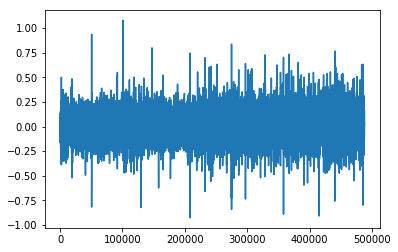

In [77]:
data_train['angular_velocity_Y'].plot()

We can see what we've seen when getting the descriptive statistics of the dataset, angular velocities are centered around the mean and look stationary

Now more let's dive into the linear acceleration ones.

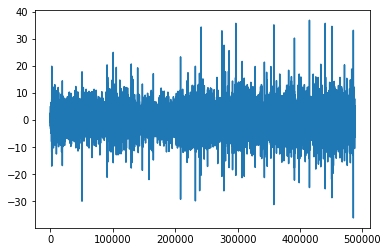

In [79]:
data_train['linear_acceleration_X'].plot()

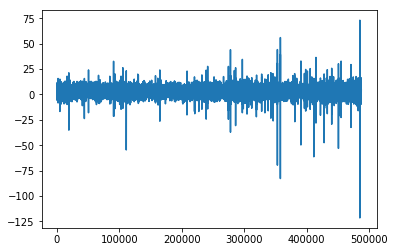

In [84]:
data_train['linear_acceleration_Y'].plot()

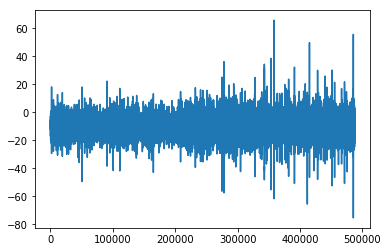

In [82]:
data_train['linear_acceleration_Z'].plot()

## Moving on to point 2. Let's now focus on the problem

The problem consist in predicting on which kind of surface out of those 9 types given the robot is moving based on its data.

So we are gonna start with a baseline model that we are gonna try to optimize.

In [99]:
data_merge = pd.merge(data_train, response_train, on = 'series_id')

In [104]:
#we check all series have only one category assigned
sum(data_merge.groupby('series_id')['surface'].nunique() !=  1)

0

Now let's drop all the id variables but series_id, so we can group by series_id means of the axis variables (orientation, acceleration, velocity)

In [108]:
data_clus = data_train.drop(['row_id','measurement_number'], axis=1)

In [110]:
data_clusmean = data_clus.groupby('series_id').mean()

Now let's fit the data for 9 clusters, as many a categories we've got to predict

In [111]:
kmeans = KMeans(n_clusters=9, random_state=0).fit(data_clusmean)

In [135]:
#let's get the labels as a dataframe and create the column for series_id so we can merge it
labels_clus = pd.DataFrame(kmeans.labels_)
labels_clus['series_id'] = range(response_train.shape[0])

In [138]:
labels_clus.columns = ['labels', 'series_id']

In [141]:
response_labeled = pd.merge(response_train, labels_clus, on='series_id')

Now we can check which are the most frequent categories for every label

In [152]:
freq_catlabel = response_labeled.groupby('labels')['surface'].value_counts()

In [161]:
freq_catlabel

labels  surface               
0       concrete                  300
        tiled                     153
        wood                      122
        carpet                     84
        fine_concrete              78
        soft_pvc                   60
        soft_tiles                 57
1       soft_pvc                  117
        wood                        9
        concrete                    8
        soft_tiles                  5
        hard_tiles_large_space      4
        tiled                       2
2       wood                      142
        soft_pvc                   64
        fine_concrete              63
        carpet                     62
        hard_tiles_large_space     38
        soft_tiles                 33
        concrete                   23
3       concrete                  122
        wood                       96
        fine_concrete              50
        hard_tiles_large_space     39
        carpet                      8
4       soft_pvc   

Ok, so let's create a dictionary with the most frequent category for every class, let's not be meticulous and just go with the most frequent ones, no matter what.

In [164]:
freq_labels_dict = ({0:'concrete', 1:'soft_pvc',2:'wood', 3:'concrete',
                    4:'soft_pvc',5:'concrete',6:'tiled',7:'soft_tiles', 8:'tiled'})

In [165]:
freq_labels_dict

{0: 'concrete',
 1: 'soft_pvc',
 2: 'wood',
 3: 'concrete',
 4: 'soft_pvc',
 5: 'concrete',
 6: 'tiled',
 7: 'soft_tiles',
 8: 'tiled'}

So, let's check it on the test

In [176]:
data_test_cluster = data_test.drop(['measurement_number', 'row_id'],axis=1)
data_test_cluster_group = data_test_cluster.groupby('series_id').mean()

In [198]:
#predict fitted clusters on the test
y_pred_test = kmeans.predict(data_test_cluster_group)

In [199]:
y_pred_test = pd.DataFrame(y_pred_test)

In [200]:
y_pred_test['series_id']  = range(len(y_pred_test))

In [201]:
y_pred_test.columns = ['surface', 'series_id']

In [202]:
y_pred_test['surface']  = y_pred_test['surface'].map(freq_labels_dict)

In [205]:
y_pred_test = y_pred_test[['series_id', 'surface']]

Let's safe the submission

In [207]:
y_pred_test.to_csv('/home/samuel/Work/coffe2/data/datacc2019/submission.csv')

In [208]:
y_pred_test.shape

(3816, 2)

## Now to the third point 3. what approach do we follow???!! Suggestions here:

* One suggestion is using a basic RNN of course
* adding lag features
* visualizations with the robots moving around the axis would be cool, but might be pointless xD